In [15]:
from fastcore.basics import store_attr
from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos
from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize, ColSplitter, RandomSplitter
from fastai.layers import Mish
from fastai.losses import FocalLossFlat
from fastai.losses import DiceLoss
from fastai.optimizer import ranger
from fastai.torch_core import tensor
from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats, SegmentationDataLoaders
from fastai.vision.learner import unet_learner
from PIL import Image
import numpy as np
from torch import nn
from torchvision.models.resnet import resnet34
import torch
import torch.nn.functional as F
from pandas import DataFrame, read_csv
from torch import Tensor
from functools import partial
import boto3
import shutil
from fastai.losses import FocalLoss as FL

def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

from fastai.callback.tensorboard import TensorBoardCallback
tensorboard_dir = Path().resolve() / 'logs'
if not tensorboard_dir.exists():
    tensorboard_dir.mkdir(parents=True)

In [2]:
import torch.cuda
torch.cuda.is_available()

torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.get_device_name(0)
s3 = boto3.client('s3')
bucket_name= 'stephenbucketsagemaker'



In [3]:

s3_tar_gzs = [x['Key'] for x in s3.list_objects(Bucket=bucket_name)['Contents'] if x['Key'].startswith('AOI') and x['Key'].endswith('.tar.gz')]
print(s3_tar_gzs)

['AOI_2_Vegas_Train.tar.gz']


In [4]:
data_dir = Path().resolve().parent.parent / "data"
if not data_dir.exists():
    data_dir.mkdir(parents=True)

for item in s3_tar_gzs:
    # __file__ doesnt exist in notebooks. I did not know that!
    dir_name = data_dir / item
    extract_dir = dir_name.__str__().split(".")[0]
    if not Path(extract_dir).exists():
        Path(extract_dir).mkdir(parents=True)
    if not dir_name.exists():
        with open(dir_name,'wb') as fp:
            s3.download_fileobj(bucket_name,item,fp)
    shutil.unpack_archive(filename=dir_name,
                          extract_dir=dir_name.__str__().split(".")[0],
                          format='gztar'
                          )

unpacked_zips = [Path(data_dir / x.split('.')[0]) for x in s3_tar_gzs]
print(unpacked_zips)

[Path('/home/stephen/BuildingDamage/ml/data/AOI_2_Vegas_Train')]


<AxesSubplot:>

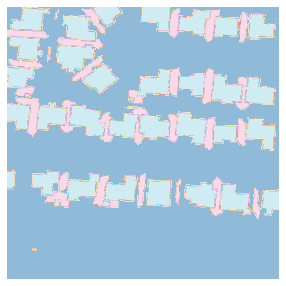

In [5]:
mask_files = (data_dir / s3_tar_gzs[0].split(".")[0] / "mask").glob("*.png")

mask = PILMask.create(next(mask_files))
mask.show()

In [6]:
# labels in mask
list(np.unique(tensor(mask)))

[0, 1, 2, 3]

In [7]:
combined_dir = data_dir / "combined"
combined_img = combined_dir / "img"
combined_mask = combined_dir / "mask"

for  merge_locs in [combined_img,combined_mask]:
    if not merge_locs.exists():
        merge_locs.mkdir(parents=True)

for files in unpacked_zips:
    for folder in ["img","mask"]:
        for extension in ['*.jpg','*.png']:
            for item in (files / folder).glob(extension):
                dst_file = (combined_dir / folder / item.name ).__str__()
                shutil.copy(src= item.__str__(), dst= dst_file.__str__())

In [8]:



fnames = get_image_files(combined_img)


def label_func(x:Path):
    return f"{combined_mask}/{x.stem}.png"

augs = [*aug_transforms(do_flip=False,flip_vert=False,max_rotate=0,max_zoom=1.3,
                                                  size=(360,360),)]


dls = SegmentationDataLoaders.from_label_func(path=combined_img,
                                              fnames=fnames,
                                              label_func=label_func,seed=42,
                                              batch_tfms=augs,bs=4,codes=["background","border","intersect","outline"]
)

/home/stephen/anaconda3/envs/sol5/lib/python3.6/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/home/stephen/anaconda3/envs/sol5/lib/python3.6/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/

/home/stephen/anaconda3/envs/sol5/lib/python3.6/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


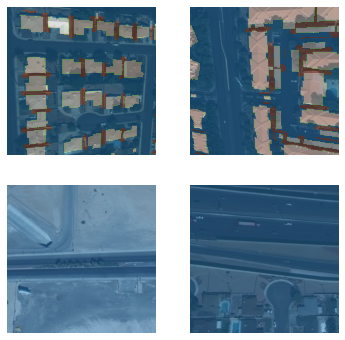

In [9]:
dls.show_batch(max_n=9)
batch = dls.one_batch()

<AxesSubplot:>

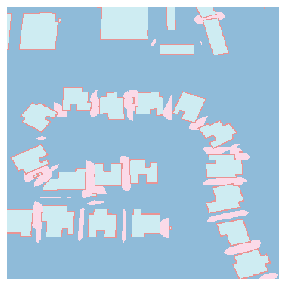

In [10]:
batch[1][1].show()

<AxesSubplot:>

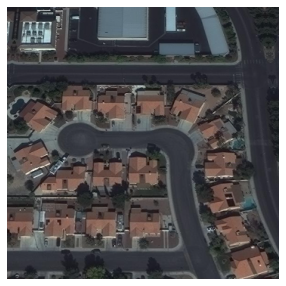

In [11]:
batch[0][1].show()

In [12]:
print (batch[0].size())
print(batch[1].size())

torch.Size([4, 3, 360, 360])
torch.Size([4, 360, 360])


In [13]:
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=1.,gamma=3):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis,gamma=gamma)
        self.dice_loss =  DiceLoss(axis, smooth)

    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)

    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)



In [23]:
%load_ext tensorboard

#TODO
%tensorboard --logdir logs
from tensorboard import notebook
notebook.list() # View open TensorBoard instances
# # Control TensorBoard display. If no port is provided,
# # the most recently launched TensorBoard is used
notebook.display(height=1000)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

Known TensorBoard instances:
  - port 6006: logdir logs (started 0:05:43 ago; pid 733501)
Selecting TensorBoard with logdir logs (started 0:05:43 ago; port 6006, pid 733501).


In [21]:
cb = TensorBoardCallback(log_dir= (tensorboard_dir /  "attempt_3").__str__())
learn = unet_learner(dls,resnet34,self_attention=True,
                     loss_func=CombinedLoss(),cbs=cb)

#learn.lr_find()

/home/stephen/anaconda3/envs/sol5/lib/python3.6/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [22]:
learn.fit_one_cycle(5,0.0001)

/home/stephen/anaconda3/envs/sol5/lib/python3.6/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch     train_loss  valid_loss  time    
0         7.715272    6.797550    04:11     


RuntimeError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 7.77 GiB total capacity; 4.25 GiB already allocated; 68.06 MiB free; 4.37 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
learn.show_results()

In [24]:
learn.save('new-stage-1')

Path('/home/stephen/AwsMLHack/data/processed/img/models/stage-1.pth')

In [25]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(10,0.001)

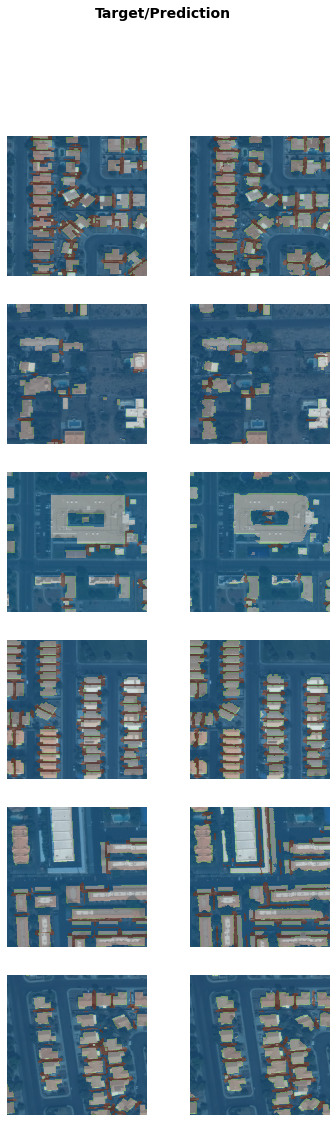

In [31]:
learn.show_results()

In [13]:
learn.save('new-stage-2')


Path('/home/stephen/AwsMLHack/data/processed/img/models/stage-2.pth')